# Re-use braking energy
* Which geographical locations are most likely to reuse braking energy?

    In this notebook, we will try to answer this question by performing clustering analysis on our data. We decided to use this approach as clustering is an effective method in capturing patterns hidden in our data.

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import folium

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

pd.set_option('display.max_columns', None)

In [2]:
# Reading the dataset
data = pd.read_csv('data/clean_clean_energy.csv')

# Fixing datatypes
data['start_date'] = pd.to_datetime(data['start_date'])
data['end_date'] = pd.to_datetime(data['end_date'])
data['ut'] = data['ut'].astype("object")
data['current_station_code'] = data['current_station_code'].astype("object")
data['next_station_code'] = data['next_station_code'].astype("object")
data['track'] = data['track'].astype("object")
data['in_service'] = data['in_service'].astype("object")

# Extra columns for analysis
data['station_curr_next'] = data['current_station'].astype('str') + '_' + data['next_station'].astype('str')
data['station_curr_next_cat'] = data['station_curr_next'].astype('category')
data['station_curr_next_catEG'] = data['station_curr_next_cat'].cat.codes

# Dropping the extra weight columns and kilometres
data.drop(columns=['net_energy_consumed_by_UT_weight',
       'auxiliary_energy_consumed_weight', 'traction_energy_weight',
       'rheostatic_energy_weight', 'regenerated_traction_energy_weight',
       'catenary_regenerated_energy_weight',
       'regenerated_energy_to_auxiliaries_weight'], inplace=True)

# List of columns to divide
columns_to_divide = [
    'net_energy_consumed_by_UT',
    'auxiliary_energy_consumed',
    'traction_energy',
    'rheostatic_energy',
    'regenerated_traction_energy',
    'catenary_regenerated_energy',
    'regenerated_energy_to_auxiliaries'
]

# Divide each specified column by 'kilometres' to normailze
for column in columns_to_divide:
    data[column + '_km'] = data[column] / data['kilometres']

### K-means Clustering

We deicded to go with the k-means algorithm, as it offered us the best results. As it is a distance-based algorithim, we pre-processed the data by using a standard scaler. After several iterations of clustering, using different feature combinations, we selected the features: net energy consumed by ut per kilometre, and regenerated traction energy per kilometre. This helped us get the most tightly packed clusters with good similarity within each cluster. Using inertia and the elbow plot, we identified the optimal number of clusters to be 3.

In [3]:
# Features to cluster by
columns_to_use = [
    'net_energy_consumed_by_UT_km',
    'regenerated_traction_energy_km', 
]

In [4]:
# Preprocessing for clustering
energy_data = data[columns_to_use]

scaler = StandardScaler()
energy_scaled = scaler.fit_transform(energy_data)

/Users/jelelel/anaconda3/envs/pda_ie_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jelelel/anaconda3/envs/pda_ie_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jelelel/anaconda3/envs/pda_ie_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jelelel/anaconda3/envs/pda_ie_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.

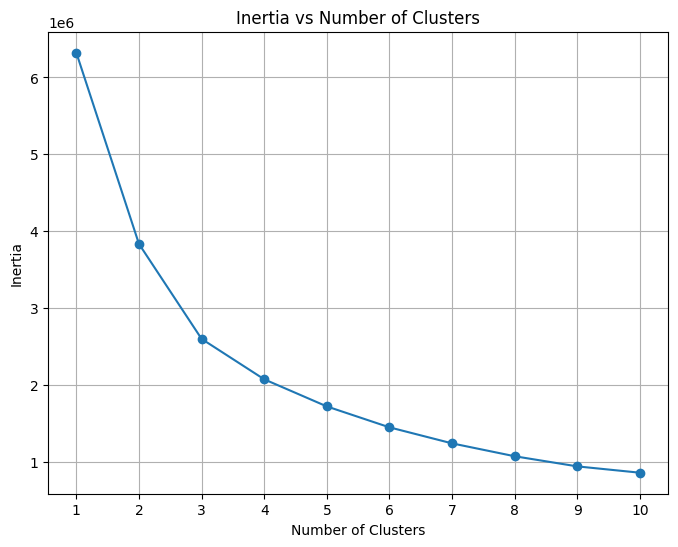

In [5]:
# Creating an elbow plot to fin the optimal amount of clusters
inertia = []

# Range of number of clusters to try
cluster_range = range(1, 11)

# Calculate inertia for different number of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(energy_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the inertia graph
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [6]:
# Clustering
kmeans = KMeans(n_clusters=3, random_state=0)  
clusters = kmeans.fit_predict(energy_scaled)

data['Cluster'] = clusters

/Users/jelelel/anaconda3/envs/pda_ie_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [7]:
# Inertia measures how tightly the clusters are packed. Lower values are better.
print("Inertia:", round(kmeans.inertia_, 2))

Inertia: 2598227.36


In [8]:
# The Davies-Bouldin index measures the average similarity ratio of each cluster with its most similar cluster. 
# Lower values indicate better clustering.
db_index = davies_bouldin_score(energy_scaled, clusters)
print("Davies-Bouldin Index:", round(db_index, 2))

Davies-Bouldin Index: 0.89


In [9]:
# The Calinski-Harabasz index, also known as the Variance Ratio Criterion, 
# is the ratio of the sum of between-cluster dispersion to within-cluster dispersion. 
# Higher values indicate better-defined clusters.
ch_score = calinski_harabasz_score(energy_scaled, clusters)
print("Calinski-Harabasz Score:", round(ch_score, 2))

Calinski-Harabasz Score: 2264634.16


### Clustering analysis and visualization

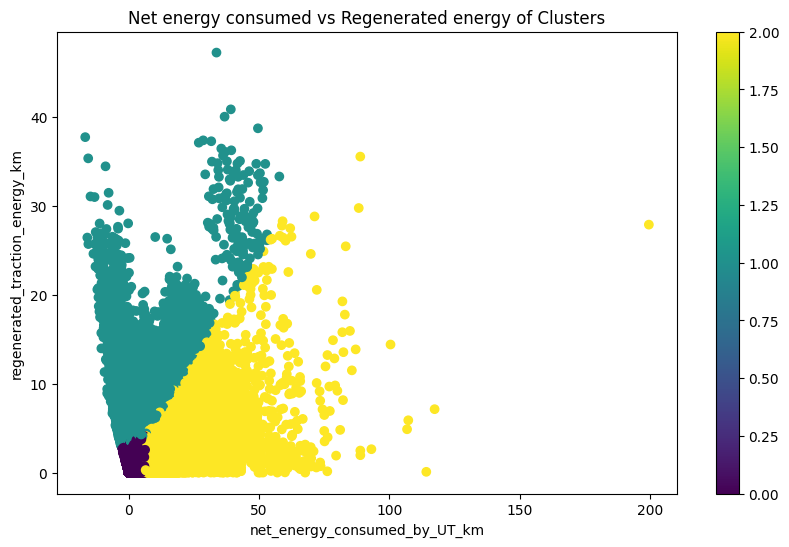

In [10]:
# Plot Clusters against the features we are interested in

plt.figure(figsize=(10, 6))
plt.scatter(data['net_energy_consumed_by_UT_km'], data['regenerated_traction_energy_km'], c=clusters, cmap='viridis', marker='o')
plt.title('Net energy consumed vs Regenerated energy of Clusters')
plt.xlabel('net_energy_consumed_by_UT_km')
plt.ylabel('regenerated_traction_energy_km')
plt.colorbar()
plt.show()


In [11]:
# Size of each cluster
percentages = data[['Cluster']].value_counts(normalize=True) * 100
percentages_rounded = percentages.round(2)

percentages_rounded

Cluster
0          48.14
2          37.18
1          14.68
Name: proportion, dtype: float64

In [12]:
# Cluster averages
cluster_group_mean = data[['Cluster', 'net_energy_consumed_by_UT_km',
    'regenerated_traction_energy_km', 'rheostatic_energy_km'
    ]].groupby('Cluster').agg('mean')

# Cluster medians
cluster_group_median = data[['Cluster', 'net_energy_consumed_by_UT_km',
    'regenerated_traction_energy_km', 'rheostatic_energy_km'
    ]].groupby('Cluster').agg('median')

In [13]:
cluster_group_mean

,net_energy_consumed_by_UT_km,regenerated_traction_energy_km,rheostatic_energy_km
Cluster,,,
0,3.641445,1.588751,-1.167714
1,1.170427,5.650356,-1.391949
2,9.263907,1.555549,-1.247844


In [14]:
cluster_group_median

,net_energy_consumed_by_UT_km,regenerated_traction_energy_km,rheostatic_energy_km
Cluster,,,
0,3.754281,1.571258,-0.880925
1,1.173472,5.024089,-1.049799
2,8.556012,1.382869,-0.897350


### Drilling down of the clusters
Here we drilldown by client line

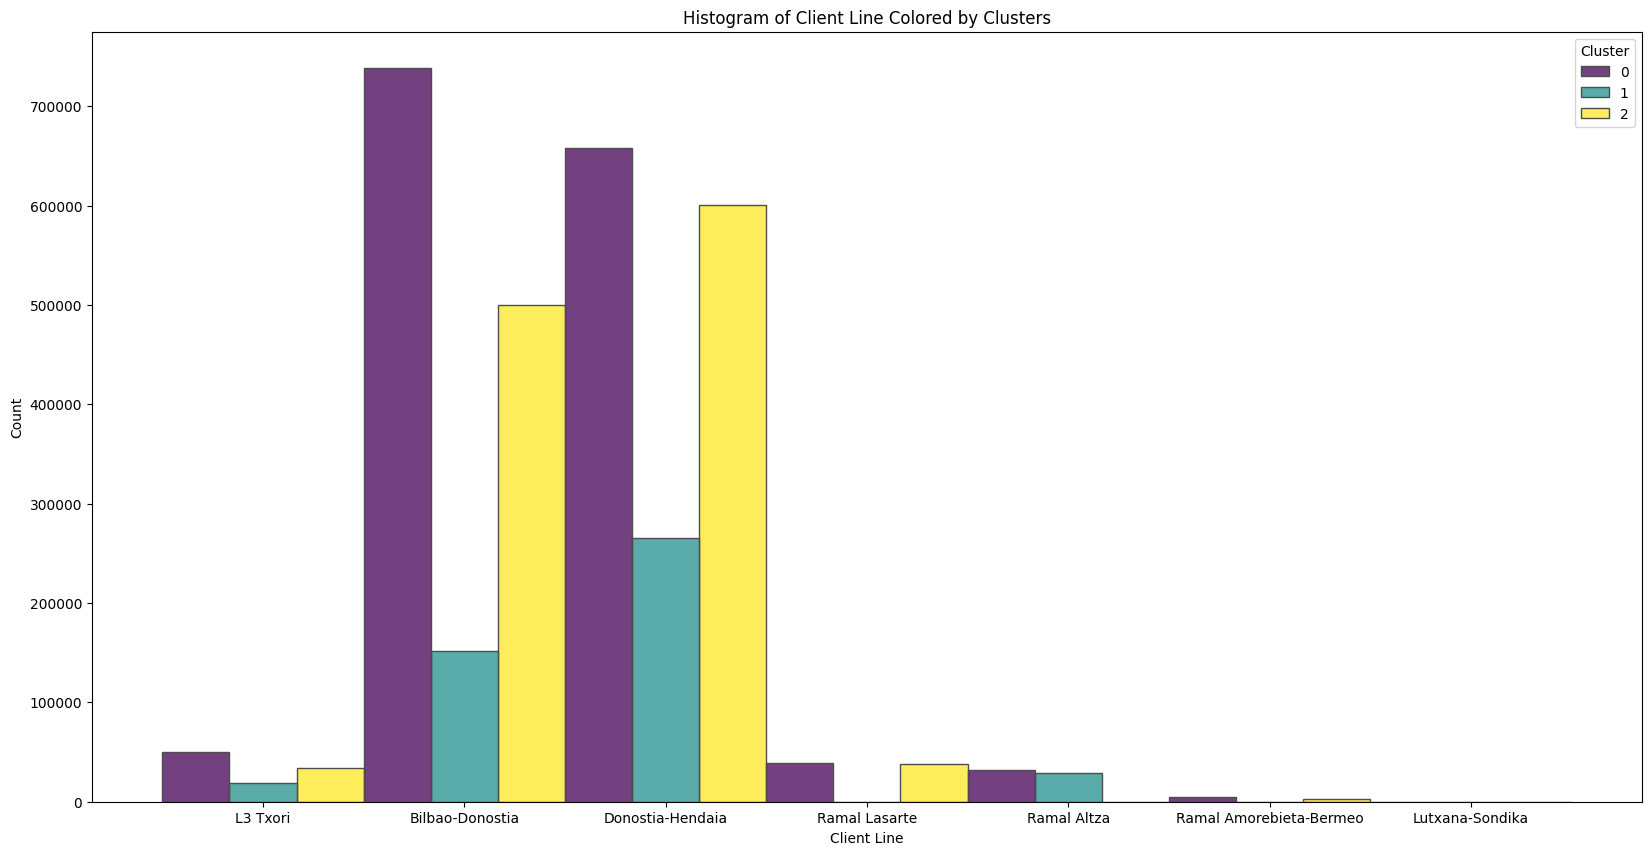

In [15]:
# Histogram of client line coloured by clusters
plt.figure(figsize=(20, 10))
sns.histplot(data=data, x='client_line', hue='Cluster', multiple='dodge', palette='viridis', edgecolor='.3')

# Set the title and labels
plt.title('Histogram of Client Line Colored by Clusters')
plt.xlabel('Client Line')
plt.ylabel('Count')


# Show the plot
plt.show()

In [16]:
# Drilling down by client_line
grouped = data.groupby(['client_line', 'Cluster']).size().reset_index(name='count')

grouped_2 = data[['client_line', 'Cluster', 
                  'net_energy_consumed_by_UT_km',
    'regenerated_traction_energy_km',
    'rheostatic_energy_km']].groupby(['client_line', 'Cluster']).agg('mean').reset_index()

check = pd.merge(grouped, grouped_2, on = ['client_line', 'Cluster'])

# Pivot the table to have clusters as columns
pivot_table = check.pivot(index=['client_line'], columns='Cluster', values='count').fillna(0)
pivot_table['cluster_1_gt_cluster_2'] = pivot_table[1] > pivot_table[2]
pivot_table['cluster_1_gt_cluster_0'] = pivot_table[1] > pivot_table[0]

In [17]:
# Size of each cluster by client line 
pivot_table

Cluster,0,1,2,cluster_1_gt_cluster_2,cluster_1_gt_cluster_0
client_line,,,,,
Bilbao-Donostia,738074.0,151245.0,499993.0,False,False
Donostia-Hendaia,657818.0,265199.0,600545.0,False,False
L3 Txori,50479.0,18359.0,33716.0,False,False
Lutxana-Sondika,2.0,0.0,1.0,False,False
Ramal Altza,31799.0,29002.0,76.0,True,False
Ramal Amorebieta-Bermeo,4811.0,176.0,2919.0,False,False
Ramal Lasarte,38722.0,20.0,37756.0,False,False


From the table above we can see that the client line Ramal Altza has more values in cluster 1 than cluster 2, which means this line regenerates more energy than having an inefficient consumption.

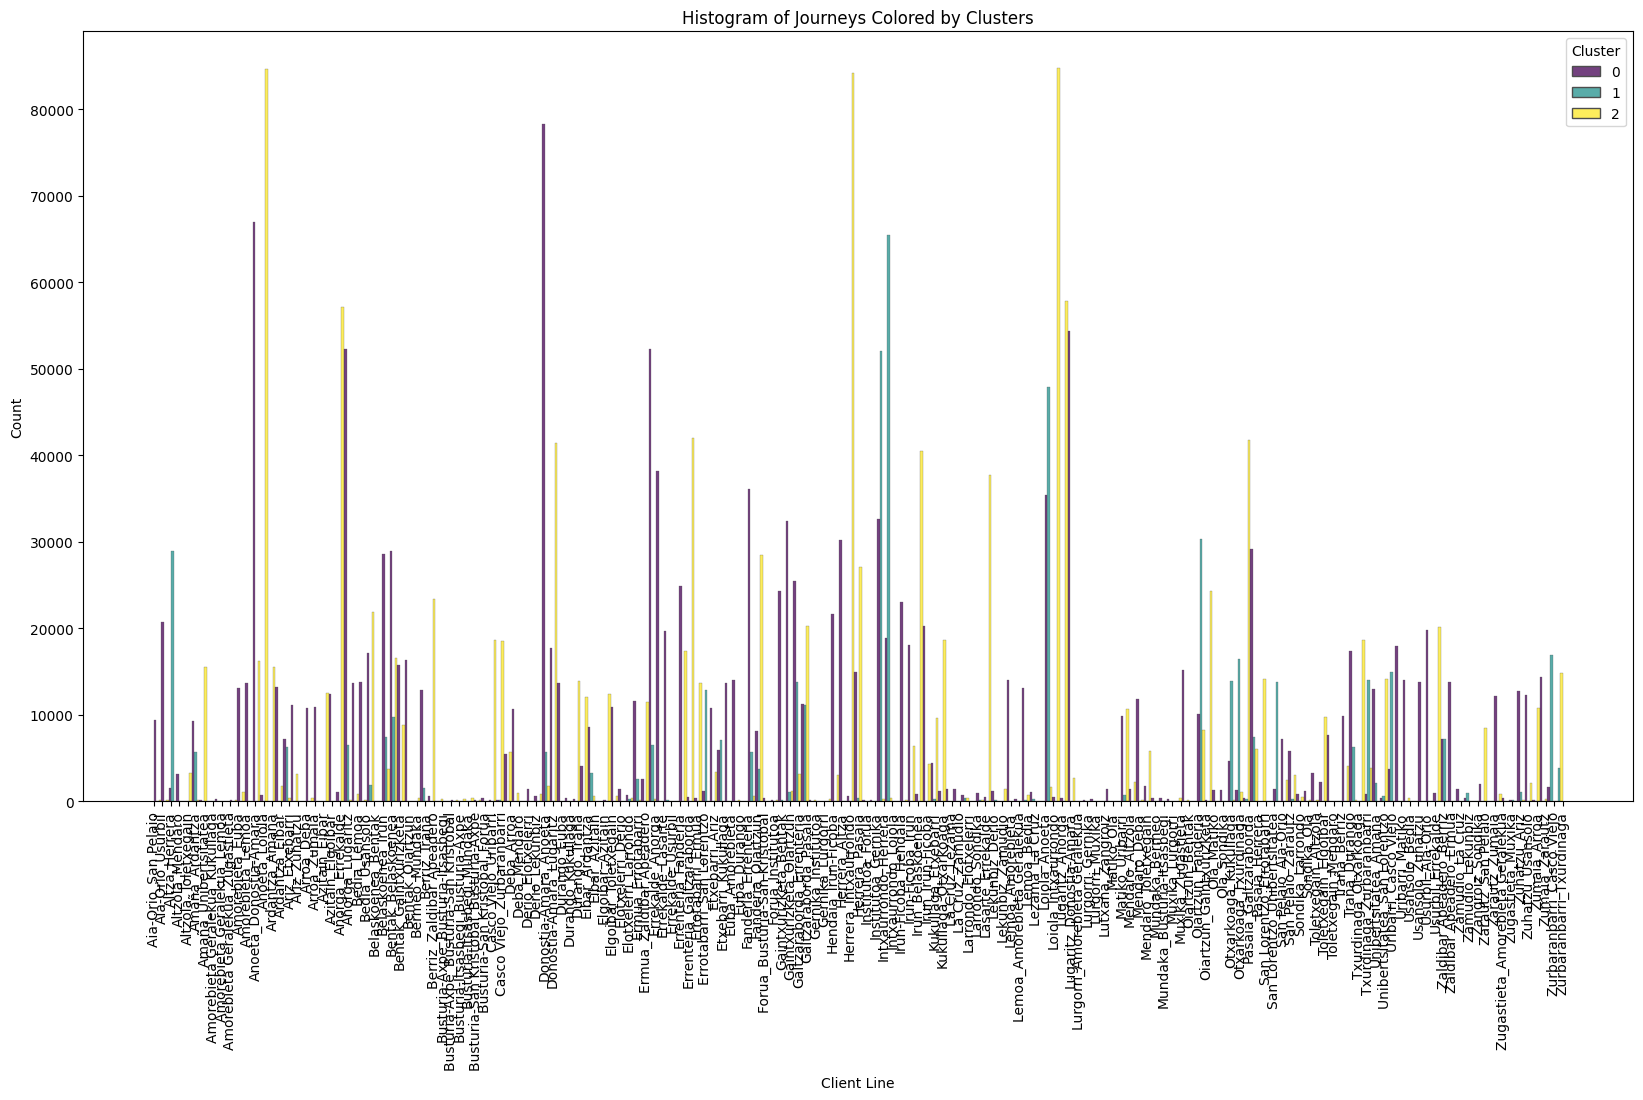

In [18]:
# Histogram of journeys coloured by clusters
plt.figure(figsize=(20, 10))
sns.histplot(data=data, x='station_curr_next_catEG', hue='Cluster', multiple='dodge', palette='viridis', edgecolor='.3')

# Set the title and labels
plt.title('Histogram of Journeys Colored by Clusters')
plt.xlabel('Client Line')
plt.ylabel('Count')

categories = data['station_curr_next_cat'].cat.categories
plt.xticks(range(len(categories)), categories, rotation=90)

# Show the plot
plt.show()

In [19]:
# Drilling down by journey
grouped = data.groupby(['client_line', 'station_curr_next', 'Cluster']).size().reset_index(name='count')

grouped_2 = data[['client_line', 'station_curr_next', 'Cluster', 
                  'net_energy_consumed_by_UT_km',
    'regenerated_traction_energy_km',
    'rheostatic_energy_km']].groupby(['client_line', 'station_curr_next', 'Cluster']).agg('mean').reset_index()

check = pd.merge(grouped, grouped_2, on = ['client_line', 'station_curr_next', 'Cluster'])

# Pivot the table to have clusters as columns
pivot_table = check.pivot(index=['client_line','station_curr_next'], columns='Cluster', values='count').fillna(0)
pivot_table['cluster_1_gt_cluster_2'] = pivot_table[1] > pivot_table[2]
pivot_table['cluster_1_gt_cluster_0'] = pivot_table[1] > pivot_table[0]

In [20]:
# Good > Bad
pivot_table[pivot_table['cluster_1_gt_cluster_2'] == True]\
    .sort_values(by= ['client_line'], ascending = False)

Cluster                                                    0        1       2  \
client_line             station_curr_next                                       
Ramal Amorebieta-Bermeo Zugastieta_Muxika              214.0    133.0    11.0   
                        Muxika_Lurgorri                258.0     11.0     8.0   
Ramal Altza             Herrera_Altza                30259.0     16.0    10.0   
                        Altza_Herrera                 1540.0  28986.0    66.0   
L3 Txori                Ola_Sondika                   1280.0     88.0    84.0   
                        Lekunbiz_Derio                1159.0    181.0     9.0   
                        Lezama_La Cruz                1126.0    317.0    35.0   
                        Larrondo_Elotxelerri           692.0    376.0   361.0   
                        Uribarri_Casco Viejo          3711.0  14987.0    31.0   
                        Zamudio_Lekunbiz               427.0    942.0    12.0   
Donostia-Hendaia        Belaskoenea_Irun             28641.0   7402.0  3723.0   
                        Pasaia_Herrera               29131.0   7435.0  6095.0   
                        Oiartzun_Fanderia            10125.0  30308.0  8232.0   
                        Loiola_Anoeta                35385.0  47866.0  1660.0   
                        Intxaurrondo_Loiola          18859.0  65490.0   448.0   
                        Intxaurrondo_Herrera         32625.0  52116.0   246.0   
                        Galtzaraborda_Errenteria     25446.0  13846.0  3147.0   
                        Gaintxurizketa_Bentak        24291.0    200.0    20.0   
                        Fanderia_Errenteria          36142.0   5759.0   686.0   
                        Donostia-Amara_Anoeta        78346.0   5695.0  1790.0   
Bilbao-Donostia         Amaña_Ardantza                9282.0   5772.0   168.0   
                        Ariz_Etxebarri                7210.0   6347.0   406.0   
                        Zuhatzu_Ariz                 12752.0   1095.0   118.0   
                        Azitain_Elgoibar             12424.0     69.0    11.0   
                        Añorga_Lugaritz              52264.0   6574.0   195.0   
                        Berriz_Traña                 12944.0   1561.0     4.0   
                        Eibar_Azitain                 8645.0   3329.0   623.0   
                        Ermua_Errotabarri            11614.0   2599.0   155.0   
                        Errekalde_Añorga             52287.0   6497.0   273.0   
                        Errekalde_Usurbil            19651.0    164.0    32.0   
                        Errotabarri_San Lorentzo      1239.0  12892.0     4.0   
                        Etxebarri_Kukullaga           5895.0   7095.0    78.0   
                        Euba_Amorebieta              13683.0     48.0    23.0   
                        Otxarkoaga_Kukullaga          4709.0  13876.0   143.0   
                        Otxarkoaga_Txurdinaga         1330.0  16471.0  1066.0   
                        San Lorentzo_Unibertsitatea   1443.0  13812.0    11.0   
                        Traña_Durango                17339.0   6352.0   122.0   
                        Txurdinaga_Zurbaranbarri       876.0  14061.0  3868.0   
                        Unibertsitatea_Amaña         13051.0   2179.0    22.0   
                        Zaldibar Apeadero_Berriz      7220.0   7241.0    41.0   
                        Zurbaranbarri_Casco Viejo     1694.0  16985.0    68.0   

Cluster                                              cluster_1_gt_cluster_2  \
client_line             station_curr_next                                     
Ramal Amorebieta-Bermeo Zugastieta_Muxika                              True   
                        Muxika_Lurgorri                                True   
Ramal Altza             Herrera_Altza                                  True   
                        Altza_Herrera                                  True   
L3 Txori                Ola_Sondika       

In [21]:
# Good > Bad & Good > Okay
pivot_table[(pivot_table['cluster_1_gt_cluster_0'] == True) & 
            (pivot_table['cluster_1_gt_cluster_2'] == True)]

Cluster                                             0        1       2  \
client_line      station_curr_next                                       
Bilbao-Donostia  Errotabarri_San Lorentzo      1239.0  12892.0     4.0   
                 Etxebarri_Kukullaga           5895.0   7095.0    78.0   
                 Otxarkoaga_Kukullaga          4709.0  13876.0   143.0   
                 Otxarkoaga_Txurdinaga         1330.0  16471.0  1066.0   
                 San Lorentzo_Unibertsitatea   1443.0  13812.0    11.0   
                 Txurdinaga_Zurbaranbarri       876.0  14061.0  3868.0   
                 Zaldibar Apeadero_Berriz      7220.0   7241.0    41.0   
                 Zurbaranbarri_Casco Viejo     1694.0  16985.0    68.0   
Donostia-Hendaia Intxaurrondo_Herrera         32625.0  52116.0   246.0   
                 Intxaurrondo_Loiola          18859.0  65490.0   448.0   
                 Loiola_Anoeta                35385.0  47866.0  1660.0   
                 Oiartzun_Fanderia            10125.0  30308.0  8232.0   
L3 Txori         Uribarri_Casco Viejo          3711.0  14987.0    31.0   
                 Zamudio_Lekunbiz               427.0    942.0    12.0   
Ramal Altza      Altza_Herrera                 1540.0  28986.0    66.0   

Cluster                                       cluster_1_gt_cluster_2  \
client_line      station_curr_next                                     
Bilbao-Donostia  Errotabarri_San Lorentzo                       True   
                 Etxebarri_Kukullaga                            True   
                 Otxarkoaga_Kukullaga                           True   
                 Otxarkoaga_Txurdinaga                          True   
                 San Lorentzo_Unibertsitatea                    True   
                 Txurdinaga_Zurbaranbarri                       True   
                 Zaldibar Apeadero_Berriz                       True   
                 Zurbaranbarri_Casco Viejo                      True   
Donostia-Hendaia Intxaurrondo_Herrera                           True   
                 Intxaurrondo_Loiola                            True   
                 Loiola_Anoeta                                  True   
                 Oiartzun_Fanderia                              True   
L3 Txori         Uribarri_Casco Viejo                           True   
                 Zamudio_Lekunbiz                               True   
Ramal Altza      Altza_Herrera                                  True   

Cluster                                       cluster_1_gt_cluster_0  
client_line      station_curr_next                                    
Bilbao-Donostia  Errotabarri_San Lorentzo                       True  
                 Etxebarri_Kukullaga                            True  
                 Otxarkoaga_Kukullaga                           True  
                 Otxarkoaga_Txurdinaga                          True  
                 San Lorentzo_Unibertsitatea                    True  
                 Txurdinaga_Zurbaranbarri                       True  
                 Zaldibar Apeadero_Berriz                       True  
                 Zurbaranbarri_Casco Viejo                      True  
Donostia-Hendaia Intxaurrondo_Herrera                           True  
                 Intxaurrondo_Loiola                            True  
                 Loiola_Anoeta                                  True  
                 Oiartzun_Fanderia                              True  
L3 Txori         Uribarri_Casco Viejo                           True  
                 Zamudio_Lekunbiz                               True  
Ramal Altza      Altza_Herrera                                  True

In [22]:
pivot_table_reset = pivot_table.reset_index(drop=False)
pivot_table_reset.drop(columns=[0,1,2], inplace=True)

In [23]:
data_plot = pivot_table_reset[(pivot_table_reset['cluster_1_gt_cluster_0'] == True) & 
                  (pivot_table_reset['cluster_1_gt_cluster_2'] == True)]

data_plot.rename(columns={'cluster_1_gt_cluster_0': 'best_regen', 'cluster_1_gt_cluster_2': 'good_regen'}, inplace=True)

data_plot[['current_station', 'next_station']] = data_plot['station_curr_next'].str.split('_', expand=True)
data_plot.drop(columns=['station_curr_next'], inplace=True)

/var/folders/wm/c9ks71w95s35n6j8r61gvcg40000gn/T/ipykernel_28851/737602496.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot.rename(columns={'cluster_1_gt_cluster_0': 'best_regen', 'cluster_1_gt_cluster_2': 'good_regen'}, inplace=True)
/var/folders/wm/c9ks71w95s35n6j8r61gvcg40000gn/T/ipykernel_28851/737602496.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot[['current_station', 'next_station']] = data_plot['station_curr_next'].str.split('_', expand=True)
/var/folders/wm/c9ks71w95s35n6j8r61gvcg40000gn/T/ipykernel_28851/737602496.py:6: Setti

In [25]:
#  Visualizing our results on the map
traject = pd.read_csv('data/final_locations.csv')
traject[['latitude', 'longitude']] = traject['Coordinates'].str.split(',', expand=True).astype(float)

plot_data_1 = traject.copy()
plot_data_1 = plot_data_1[['client_line', 'current_station', 'latitude', 'longitude']]

plot_data_1.rename(columns={'latitude': 'latitude_current',
                            'longitude': 'longitude_current',
                            }, inplace=True)

plot_data_2 = traject.copy()
plot_data_2 = plot_data_2[['client_line', 'current_station', 'latitude', 'longitude']]

plot_data_2.rename(columns={'current_station': 'next_station',
                            'latitude': 'latitude_next',
                            'longitude': 'longitude_next',
                            }, inplace=True)

merge_1 = pd.merge(data_plot, plot_data_1, on=['client_line', 'current_station'],how='inner')
merge_2 = pd.merge(merge_1, plot_data_2, on=['client_line', 'next_station'],how='inner')

In [26]:
color_dict = {
    'Bilbao-Donostia': 'blue',
    'Ramal Amorebieta-Bermeo': 'green',
    'Ramal Lasarte': 'red', 
    'Donostia-Hendaia': 'pink',
    'L3 Txori': 'black',
    'Lutxana-Sondika': 'gray',
    'Ramal Altza': 'orange'
    # Add other client lines and their corresponding colors here
}

def get_marker_color(client_line):
    return color_dict.get(client_line)

# Initialize a Folium map
mymap = folium.Map(location=[43.272488, -2.393647], zoom_start=9.5)

# Add lines and markers
for _, row in merge_2.iterrows():
    line_color = color_dict.get(row['client_line'], 'black')  # Default to black if client line not in dictionary
    
    # Add line
    folium.PolyLine(
        locations=[
            (row['latitude_current'], row['longitude_current']),
            (row['latitude_next'], row['longitude_next'])
        ],
        color=line_color,
        weight=5,
        opacity=0.8
    ).add_to(mymap)

    # Add markers for the current and next stations
    folium.Marker(
        location=[row['latitude_current'], row['longitude_current']],
        popup=f"Current: {row['current_station']} ({row['client_line']})",
        icon=folium.Icon(color=get_marker_color(row['client_line']))  # Use white marker with line color for icon color
    ).add_to(mymap)
    
    folium.Marker(
        location=[row['latitude_next'], row['longitude_next']],
        popup=f"Next: {row['next_station']} ({row['client_line']})",
        icon=folium.Icon(color=get_marker_color(row['client_line']))  # Use white marker with line color for icon color
    ).add_to(mymap)

# Create a legend as a separate HTML string
legend_html = '''
     <div style="position: fixed; 
                 bottom: 30px; left: 30px; width: 150px; height: 170px; 
                 border:2px solid grey; z-index:9999; font-size:10px;
                 background-color:white;
                 ">
     &nbsp;<b> Client Line Legend </b><br>
     &nbsp;<i class="fa fa-map-marker fa-2x" style="color:blue"></i>&nbsp; Bilbao-Donostia<br>
     &nbsp;<i class="fa fa-map-marker fa-2x" style="color:green"></i>&nbsp; Ramal Amorebieta-Bermeo<br>
     &nbsp;<i class="fa fa-map-marker fa-2x" style="color:red"></i>&nbsp; Ramal Lasarte<br>
     &nbsp;<i class="fa fa-map-marker fa-2x" style="color:pink"></i>&nbsp; Donostia-Hendaia<br>
     &nbsp;<i class="fa fa-map-marker fa-2x" style="color:black"></i>&nbsp; L3 Txori<br>
     &nbsp;<i class="fa fa-map-marker fa-2x" style="color:gray"></i>&nbsp; Lutxana-Sondika<br>
     &nbsp;<i class="fa fa-map-marker fa-2x" style="color:orange"></i>&nbsp; Ramal Altza<br>
     </div>
     '''

mymap.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
mymap.save('map.html')
mymap

### Creating a classification model (potential fututre work)

In [27]:
df = data.copy()
df.drop(columns=['current_station_code', 'next_station_code', 'station_curr_next', 'station_curr_next_cat', 
                 'station_curr_next_catEG', 'net_energy_consumed_by_UT_km',
                 'auxiliary_energy_consumed_km', 'traction_energy_km',
                 'rheostatic_energy_km', 'regenerated_traction_energy_km',
                 'catenary_regenerated_energy_km', 'regenerated_energy_to_auxiliaries_km'], inplace = True)

# Extract features from datetime objects
df['start_year'] = df['start_date'].dt.year
df['start_month'] = df['start_date'].dt.month
df['start_day'] = df['start_date'].dt.day
df['start_hour'] = df['start_date'].dt.hour

df['end_year'] = df['end_date'].dt.year
df['end_month'] = df['end_date'].dt.month
df['end_day'] = df['end_date'].dt.day
df['end_hour'] = df['end_date'].dt.hour

# Calculate duration in seconds between start_date and end_date
df['duration'] = (df['end_date'] - df['start_date']).dt.total_seconds()

df.drop(columns = ['start_date', 'end_date'], inplace=True)

In [28]:
# Select all columns with dtype 'object'
categorical_columns = df.select_dtypes(include=['object']).columns

# Initialize a dictionary to store the label encoders
label_encoders = {}

# Apply label encoding to each categorical column
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=['Cluster'])
y = df['Cluster']

# Normalize/Standardize features if necessary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a RandomForest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [29]:
rf_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1)
print('RandomForest 5-fold CV Accuracy:', rf_scores)
print('RandomForest 5-fold CV Mean Accuracy:', rf_scores.mean())

RandomForest 5-fold CV Accuracy: [0.88777697 0.72740345 0.80161578 0.78649734 0.79808018]
RandomForest 5-fold CV Mean Accuracy: 0.800274743592286


In [30]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('RandomForest Test Accuracy:', accuracy_score(y_test, y_pred_rf))
print('RandomForest Test Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf))
print('RandomForest Test Classification Report:\n', classification_report(y_test, y_pred_rf))

RandomForest Test Accuracy: 0.997726251668927
RandomForest Test Confusion Matrix:
 [[455724    607    257]
 [   704 137848    130]
 [   332    126 352486]]
RandomForest Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    456588
           1       0.99      0.99      0.99    138682
           2       1.00      1.00      1.00    352944

    accuracy                           1.00    948214
   macro avg       1.00      1.00      1.00    948214
weighted avg       1.00      1.00      1.00    948214

